In [28]:
import numpy as np
import os
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, log_loss
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score
from glob import glob

In [29]:
nrows = 6
ncols = 4
pic_index = 0

BASE_DATA_FOLDER = "data"
TRAIN_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

images = []
labels = []

for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpeg")):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (100,100))
        image = np.stack((image,)*3, axis=-1)
        images.append(image)
        labels.append(class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (100,100))
        image = np.stack((image,)*3, axis=-1)    
        images.append(image)
        labels.append(class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (100,100))
        image = np.stack((image,)*3, axis=-1)
        images.append(image)
        labels.append(class_folder_name)

In [30]:
images = np.array(images)
labels = np.array(labels)
pre = preprocessing.LabelEncoder()
pre.fit(labels)
labels_numeric = pre.transform(labels)
Num_Class = 3

def OneHotEncoded(y_train):
    y_t=np.zeros((len(y_train),Num_Class), dtype=int)
    for i,x in enumerate(y_train):
        y_t[i][int(x)-1]=1
    return y_t

labels = OneHotEncoded(labels_numeric)

X_train, X_test= train_test_split(images, test_size=0.2, random_state=48)
y_train, y_test= train_test_split(labels, test_size=0.2, random_state=48)
#X_train = X_train.reshape(57, 224, 224, 3)
#X_test = X_test.reshape(51, 224, 224, 3)

In [23]:
len(X_train)

57

In [31]:
train_vgg_bf = X_train.reshape(X_train.shape[0],-1)
valid_vgg_bf = X_test.reshape(X_test.shape[0],-1)

In [32]:
compare_loss={}
compare_accuracy = {}
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
logreg.fit(train_vgg_bf, (y_train * range(Num_Class)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)
compare_loss['Vgg16']=log_loss(y_test, valid_probs)
compare_accuracy['Vgg16']=accuracy_score((y_test * range(Num_Class)).sum(axis=1), valid_preds)
print('Validation VGG LogLoss {}'.format(compare_loss['Vgg16']))
print('Validation VGG Accuracy {}'.format(compare_accuracy['Vgg16']))
y_lr_test = (y_test * range(Num_Class)).sum(axis=1)

Validation VGG LogLoss 1.7889202460934717
Validation VGG Accuracy 0.8


In [33]:
print ('Accuracy:', accuracy_score(y_lr_test, valid_preds))
print ('F1 score:', f1_score(y_lr_test, valid_preds, average='macro'))
print ('Recall:', recall_score(y_lr_test, valid_preds, average='macro'))
print ('Precision:', precision_score(y_lr_test, valid_preds, average='macro'))
print ('\n clasification report:\n', classification_report(y_lr_test,valid_preds))
print ('\n confussion matrix:\n',confusion_matrix(y_lr_test, valid_preds))

X = train_vgg_bf
numpy_labels = y_train
numpy_all = logreg.predict_proba(X)

Accuracy: 0.8
F1 score: 0.7648351648351648
Recall: 0.7857142857142857
Precision: 0.7777777777777777

 clasification report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.67      1.00      0.80         4
           2       1.00      0.86      0.92         7

    accuracy                           0.80        15
   macro avg       0.78      0.79      0.76        15
weighted avg       0.82      0.80      0.80        15


 confussion matrix:
 [[2 2 0]
 [0 4 0]
 [1 0 6]]


[[2 2 0]
 [0 4 0]
 [1 0 6]]


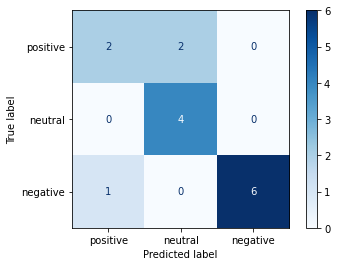

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_lr_test, valid_preds)
print(cm)

CATEGORIES=['positive','neutral','negative']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [35]:
clusterer = KMeans(n_clusters=3)
preds = clusterer.fit_predict(X)
centers = clusterer.cluster_centers_
score = silhouette_score(X, preds)
print ("Sillouette Score using K-Means", score)

Sillouette Score using K-Means 0.14854160957451182
